АБ тестування на сайті проводиться для порівняння конверсії в ключову дію на різних фонів. Група А використовує білий фон, а група Б — темний. Метою є визначити, який фон сприяє вищій конверсії та покращує взаємодію користувачів із сайтом.

План дій:
- Огляд даних
- Аналіз даних
- Аналіз A/B тесту
- Висновки

Доступні дані:
- User ID: Слугує ідентифікатором для кожного користувача.
- Group: ідентифікатор групи (A, B).
- Page Views: Кількість сторінок, переглянутих користувачем під час сеансу.
- Time Spent: Загальна кількість часу в секундах, яку користувач провів на сайті під час сесії.
- Conversion: Показує, чи виконав користувач ключову дію (так/ні).
- Device: Тип пристрою, який використовується для доступу до сайту.
- Location: Країна у Великобританії, в якій знаходиться користувач.

In [267]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.stats.proportion import proportions_ztest

In [268]:
!ls 

Untitled.ipynb	ab_testing.csv


In [269]:
df = pd.read_csv('ab_testing.csv')

# Огляд даних

In [270]:
df.head()

User ID Group  Page Views  Time Spent Conversion   Device          Location
0    14292     B           3         424         No   Mobile  Northern Ireland
1    11682     A           9         342         No   Mobile          Scotland
2    19825     A           2         396         No  Desktop  Northern Ireland
3    16080     B           4         318         No  Desktop             Wales
4    18851     A           1         338        Yes  Desktop          Scotland

In [271]:
df.shape

(5000, 7)

In [272]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   User ID     5000 non-null   int64 
 1   Group       5000 non-null   object
 2   Page Views  5000 non-null   int64 
 3   Time Spent  5000 non-null   int64 
 4   Conversion  5000 non-null   object
 5   Device      5000 non-null   object
 6   Location    5000 non-null   object
dtypes: int64(3), object(4)
memory usage: 273.6+ KB


In [273]:
df.duplicated().sum()

0

In [274]:
df.describe()

User ID   Page Views   Time Spent
count   5000.000000  5000.000000  5000.000000
mean   14925.159000     7.537600   242.512600
std     2869.153773     4.022465   118.254153
min    10001.000000     1.000000    40.000000
25%    12456.250000     4.000000   137.000000
50%    14858.500000     8.000000   243.000000
75%    17379.750000    11.000000   346.000000
max    19995.000000    14.000000   449.000000

In [275]:
df.describe(include='object')

Group Conversion   Device  Location
count   5000       5000     5000      5000
unique     2          2        2         4
top        A         No  Desktop  Scotland
freq    2519       4515     2538      1281

In [276]:
columns = [i.lower() for i in df.columns]
df.columns = columns

df.rename(columns={'user id': 'user_id', 
                   'page views': 'page_views', 
                   'time spent': 'time_spent'}, inplace=True)

df['conversion'] = df['conversion'].map({'Yes': 1, 'No': 0})
df['time_spent_one_page'] = df['time_spent'] / df['page_views']

# Аналіз даних

In [277]:
df.head()

user_id group  page_views  time_spent  conversion   device  \
0    14292     B           3         424           0   Mobile   
1    11682     A           9         342           0   Mobile   
2    19825     A           2         396           0  Desktop   
3    16080     B           4         318           0  Desktop   
4    18851     A           1         338           1  Desktop   

           location  time_spent_one_page  
0  Northern Ireland           141.333333  
1          Scotland            38.000000  
2  Northern Ireland           198.000000  
3             Wales            79.500000  
4          Scotland           338.000000

In [278]:
shape = df.shape
unq_users = set(df['user_id'])
unq_users_a = set(df[df['group'] == 'A']['user_id'])
unq_users_b = set(df[df['group'] == 'B']['user_id'])

print(f"""
    Розмір датасета {shape[0]} рядків і {shape[1]} стовбців.
    В АБ тесті приймало участь {len(unq_users)} юзерів.
    В групі А {len(unq_users_a)} унікальних користувачів, в групі Б {len(unq_users_b)}.
    Перетину юзерів між групами {'немає' if len(unq_users_a - unq_users_b) == len(unq_users_a) else 'є'}.
""")


    Розмір датасета 5000 рядків і 8 стовбців.
    В АБ тесті приймало участь 5000 юзерів.
    В групі А 2519 унікальних користувачів, в групі Б 2481.
    Перетину юзерів між групами немає.



In [279]:
df.head()

user_id group  page_views  time_spent  conversion   device  \
0    14292     B           3         424           0   Mobile   
1    11682     A           9         342           0   Mobile   
2    19825     A           2         396           0  Desktop   
3    16080     B           4         318           0  Desktop   
4    18851     A           1         338           1  Desktop   

           location  time_spent_one_page  
0  Northern Ireland           141.333333  
1          Scotland            38.000000  
2  Northern Ireland           198.000000  
3             Wales            79.500000  
4          Scotland           338.000000

In [280]:
df['device'].value_counts(normalize=True)

device
Desktop    0.5076
Mobile     0.4924
Name: proportion, dtype: float64

In [281]:
df['location'].value_counts(normalize=True)

location
Scotland            0.2562
England             0.2492
Northern Ireland    0.2484
Wales               0.2462
Name: proportion, dtype: float64

In [282]:
def grouped_data(df, info_column, grp_column=None):
    if grp_column is None:
        data = df.groupby(['group'])[info_column].agg(['mean'])
    else:
        data = df.groupby(['group', grp_column])[info_column].agg(['mean'])
    
    print(data)
    
    data.plot(kind='bar')
    plt.title(info_column)
    plt.show();

           mean
group          
A      7.581580
B      7.492946


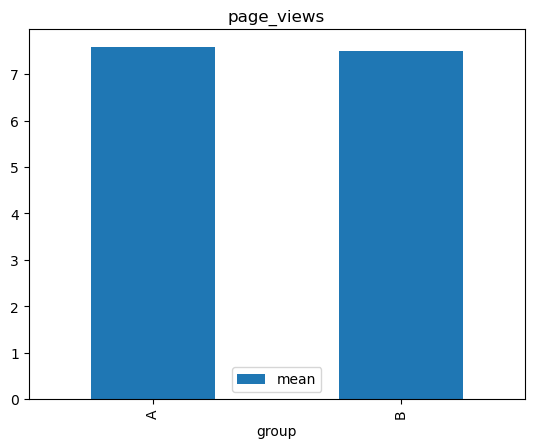

             mean
group            
A      241.733227
B      243.303910


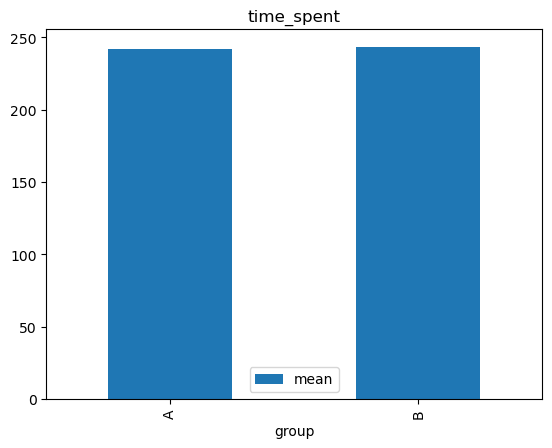

           mean
group          
A      0.053990
B      0.140669


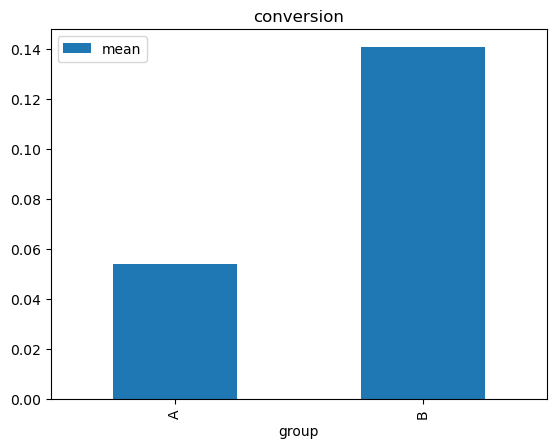

            mean
group           
A      57.401674
B      56.152439


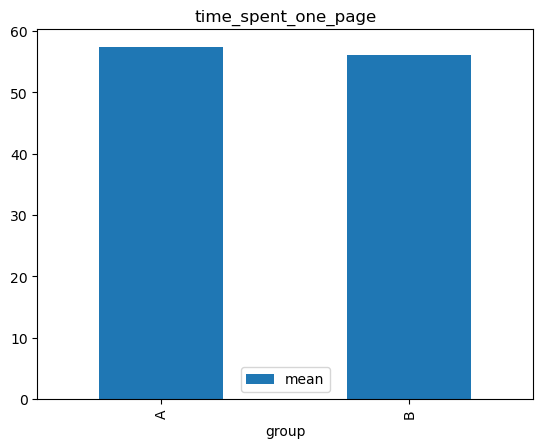

                   mean
group device           
A     Desktop  7.519293
      Mobile   7.642353
B     Desktop  7.540958
      Mobile   7.440607


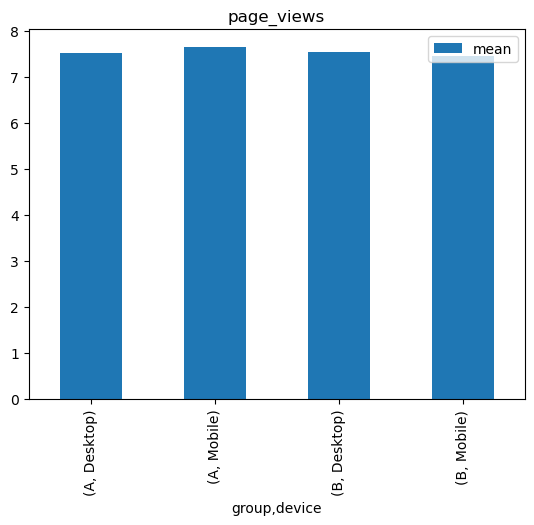

                     mean
group device             
A     Desktop  243.131029
      Mobile   240.369412
B     Desktop  243.238022
      Mobile   243.375737


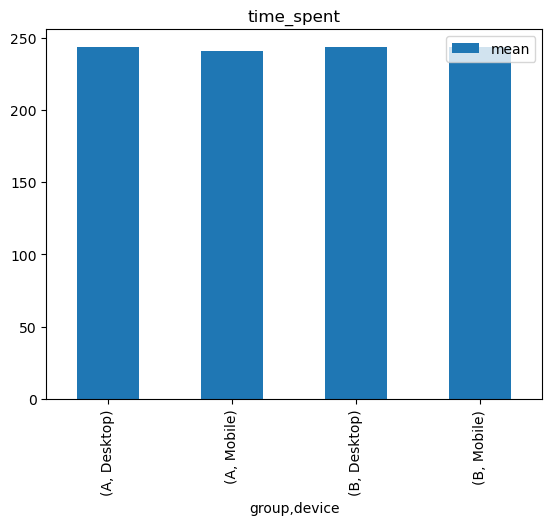

                   mean
group device           
A     Desktop  0.058682
      Mobile   0.049412
B     Desktop  0.139104
      Mobile   0.142376


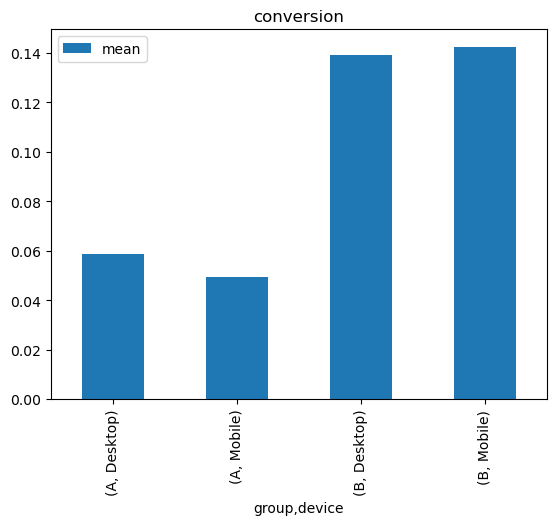

                    mean
group device            
A     Desktop  58.438062
      Mobile   56.390485
B     Desktop  54.713821
      Mobile   57.720739


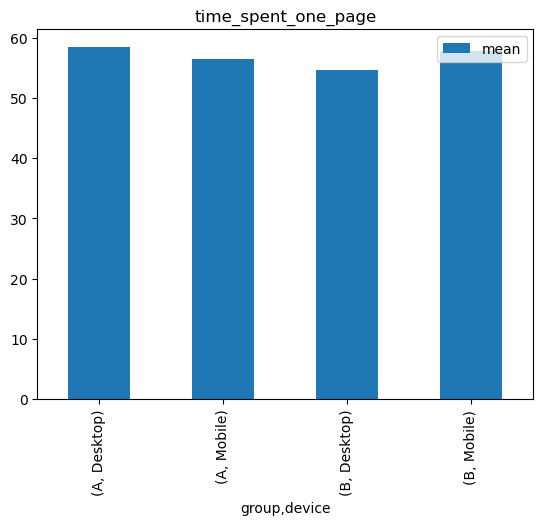

                            mean
group location                  
A     England           7.590759
      Northern Ireland  7.648208
      Scotland          7.632836
      Wales             7.453100
B     England           7.632812
      Northern Ireland  7.326433
      Scotland          7.530278
      Wales             7.480066


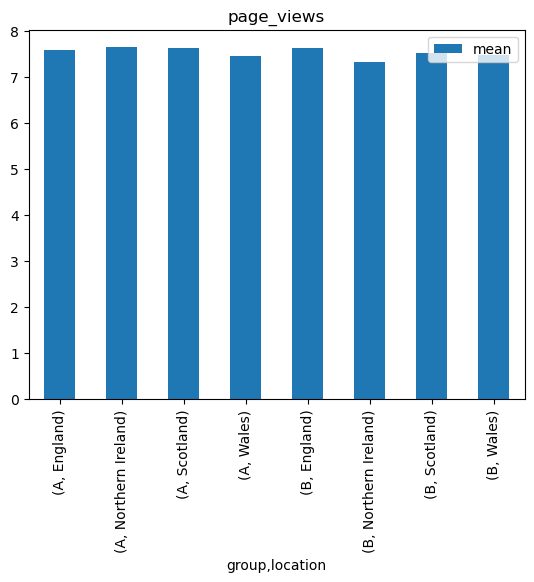

                              mean
group location                    
A     England           241.712871
      Northern Ireland  238.661238
      Scotland          237.970149
      Wales             248.759936
B     England           249.857812
      Northern Ireland  247.558917
      Scotland          230.235679
      Wales             245.161130


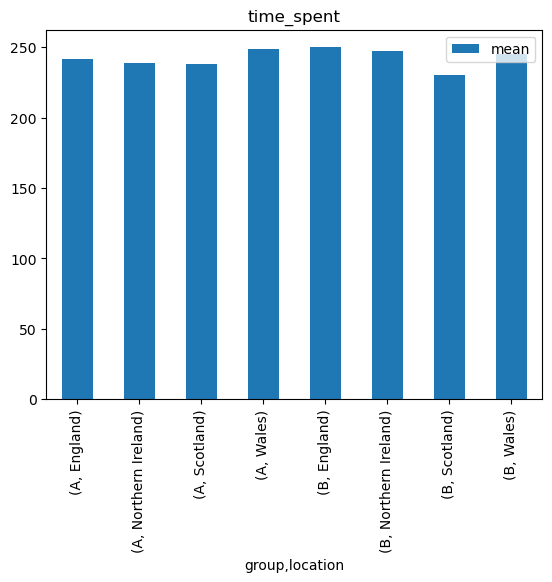

                            mean
group location                  
A     England           0.069307
      Northern Ireland  0.050489
      Scotland          0.049254
      Wales             0.047695
B     England           0.146875
      Northern Ireland  0.114650
      Scotland          0.150573
      Wales             0.151163


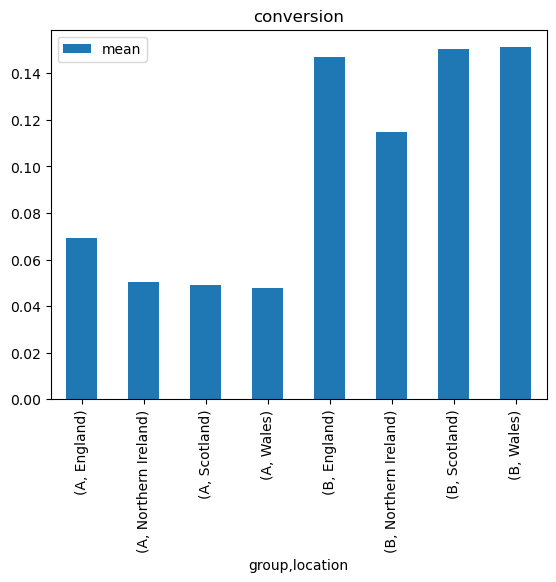

                             mean
group location                   
A     England           55.360413
      Northern Ireland  55.789421
      Scotland          57.131448
      Wales             61.229940
B     England           52.924150
      Northern Ireland  62.933166
      Scotland          49.946061
      Wales             58.810090


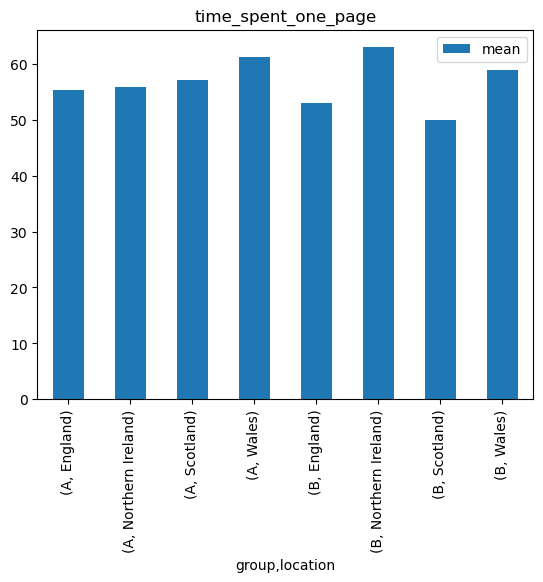

In [283]:
for i in [None, 'device', 'location']:
    for o in ['page_views', 'time_spent', 'conversion', 'time_spent_one_page']:
        grouped_data(df, o, grp_column=i)

In [284]:
df.head()

user_id group  page_views  time_spent  conversion   device  \
0    14292     B           3         424           0   Mobile   
1    11682     A           9         342           0   Mobile   
2    19825     A           2         396           0  Desktop   
3    16080     B           4         318           0  Desktop   
4    18851     A           1         338           1  Desktop   

           location  time_spent_one_page  
0  Northern Ireland           141.333333  
1          Scotland            38.000000  
2  Northern Ireland           198.000000  
3             Wales            79.500000  
4          Scotland           338.000000

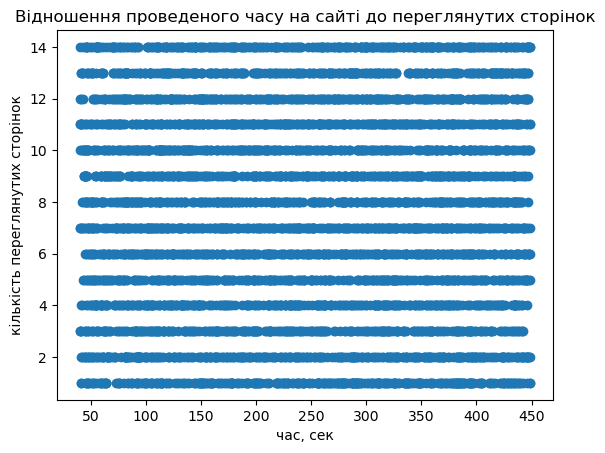

In [285]:
plt.scatter(df['time_spent'], df['page_views'])

plt.title('Відношення проведеного часу на сайті до переглянутих сторінок')
plt.xlabel('час, сек')
plt.ylabel('кількість переглянутих сторінок')

plt.show()

In [286]:
bp = []
for i in sorted(df['page_views'].unique()):
    bp.append(list(df[df['page_views'] == i]['time_spent'].values))

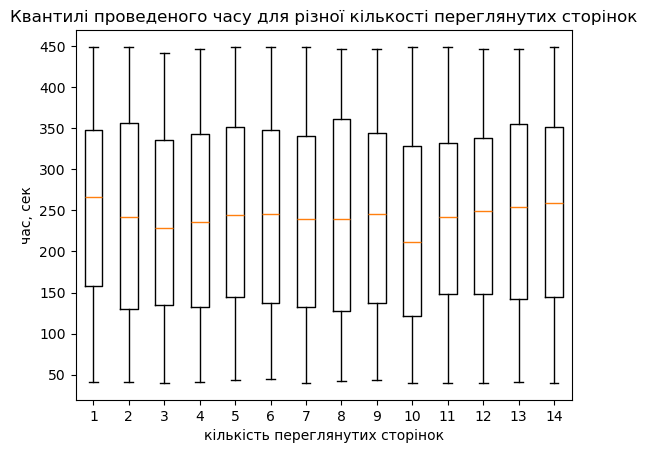

In [287]:
plt.boxplot(bp)

plt.title('Квантилі проведеного часу для різної кількості переглянутих сторінок')
plt.xlabel('кількість переглянутих сторінок')
plt.ylabel('час, сек')

plt.show()

У тестовій групі незначно менше переглядають сторінок — 7.49 проти 7.58. На ПК кількість сторінок однакова, на телефоні зменшилася — 7.44 проти 7.64.

У тестовій групі незначно більше проводять часу на сайті — 243.3 проти 241.7. Оскільки це штучно згенеровані дані, якщо дивитися на середні показники часу, проведеного на одній сторінці, то в тестовій групі ці показники будуть меншими, ніж у контрольній. Це не може бути так, якщо враховувати час, проведений на всіх сторінках.

Конверсія вища у тестовій групі — 0.14 проти 0.05.

За локаціями:
- кількість переглянутих сторінок незначно збільшилася в Англії (7.63–7.59) та Уельсі (7.48–7.45), зменшилася в Північній Ірландії (7.32–7.64) та Шотландії (7.53–7.63).
- кількість часу, проведеного на сайті, збільшилася в Англії (249–241) та Північній Ірландії (247–238), зменшилася в Шотландії (230–237) і незначно в Уельсі (245–248).
- конверсія стабільно вища у тестовій групі в кожній локації.

# Аналіз A/B тесту

Сформуємо гіпотези та будемо перевіряти їх при alpha = 0.05.

- H0: При темному фоні на сайті конверсія такаж як на білому.
- H1: При темному фоні на сайті конверсія більше ніж на білому.

In [289]:
alpha = 0.05

a = df[df['group'] == 'A']['conversion']
b = df[df['group'] == 'B']['conversion']

z_stat, p_val = proportions_ztest([a.sum(), b.sum()], [a.count(), b.count()])

if p_val > alpha:
    print('Нульову гіпотезу не відкидаємо, конверсія в групах однакова.')
else:
    print('Нульову гіпотезу відкидаємо, конверсія в тестовій групі більше ніж в контрольній.')

Нульову гіпотезу відкидаємо, конверсія в тестовій групі більше ніж в контрольній.


# Висновки

Розмір датасета 5000 рядків і 8 стовбців.
В АБ тесті приймало участь 5000 юзерів.
В групі А 2519 унікальних користувачів, в групі Б 2481.
Перетину юзерів між групами немає.

У тестовій групі незначно менше переглядають сторінок — 7.49 проти 7.58. На ПК кількість сторінок однакова, на телефоні зменшилася — 7.44 проти 7.64.

У тестовій групі незначно більше проводять часу на сайті — 243.3 проти 241.7. Оскільки це штучно згенеровані дані, якщо дивитися на середні показники часу, проведеного на одній сторінці, то в тестовій групі ці показники будуть меншими, ніж у контрольній. Це не може бути так, якщо враховувати час, проведений на всіх сторінках.

Конверсія вищая у тестовій групі — 0.14 проти 0.05.

За локаціями:
- кількість переглянутих сторінок незначно збільшилася в Англії (7.63–7.59) та Уельсі (7.48–7.45), зменшилася в Північній Ірландії (7.32–7.64) та Шотландії (7.53–7.63).
- кількість часу, проведеного на сайті, збільшилася в Англії (249–241) та Північній Ірландії (247–238), зменшилася в Шотландії (230–237) і незначно в Уельсі (245–248).
- конверсія стабільно вища у тестовій групі в кожній локації.

Аналіз АБ тесту показав, що конверсія в тестовій групі **більше** ніж в контрольній і становить **0.14 проти 0.05**.